In [2]:
import os
import re
from keras.optimizers import Adam
from keras import backend as K
import numpy as np
if('tensorflow' == K.backend()):
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    
from math import ceil
#network
from models.keras_mobilenet_v2_ssdlite_subtraction_lstm_base import mobilenet_v2_ssd
from losses.keras_ssd_loss import SSDLoss
from data_generatornowinuse.object_detection_2d_data_generator_subtraction import DataGenerator
from utils.object_detection_2d_geometric_ops import Resize
from utils.object_detection_2d_photometric_ops import ConvertTo3Channels
from utils.data_augmentation_chain_original_ssd import SSDDataAugmentation
from utils.coco import get_coco_category_maps
from utils.ssd_input_encoder import SSDInputEncoder
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from matplotlib import pyplot as plt
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.


In [3]:
#SSD configuation

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
timesteps = 1 # Time step for sequence input frames
#mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
#swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 7 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO

#??what decide the anchor box scaling factor??
#scale，对于每个featuremap 它的anchor的计算 Sk = Smin +[(Smax - Smin)/(m-1)]*(k-1)
#其中Smin默认是0.2,表示最低层的scale为0.2,默认Smax 为0.9,同时也拥有长宽比alpha，所以能求得每个anchor的宽Sk*sqr(alpha)和高Sk/sqr(alpha)
#默认 m=6 ， scale:[0.2,0.34,0.48,0.62,0.76,0.9]
#结果乘以图片实际款高即可得到anchor的实际大小
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # min 0.1 max 1.05 The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
#长宽比# 4 6 6 6 4 4
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters

# ??What's the meaning of the factor below??
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # 特征图cell的大小The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # 偏移值，用来确定先验框中心The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
#?? Didn't figure out the meaning of the param below
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

In [4]:
#Build the model
K.clear_session()

model = mobilenet_v2_ssd(image_size=(img_height, img_width, img_channels),
                timesteps=timesteps,
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords)
# train from scratch.0, 2.0, 0.5, 3.0, 1.0/3.0],h, no weights to load
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
# set_trainable(r"(ssd\_[cls|box].*)", model)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

print(model.summary())
#Total params: 3,160,240
#Trainable params: 3,108,888













Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          (10, 1, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
time_distributed_11 (TimeDistri (10, 1, 302, 301, 3) 0           img_input[0][0]                  
__________________________________________________________________________________________________
time_distributed_12 (TimeDistri (10, 1, 150, 150, 32 864         time_distributed_11[0][0]        
__________________________________________________________________________________________________
ti

In [5]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator()#(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator()#(load_images_into_memory=False, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets. This can take a while.

# TODO: Set the paths to the datasets here.

# The directories that contain the images.
VOC_2007_images_dir = './data_index/data/pic/'

# The directories that contain the annotations.
VOC_2007_annotations_dir = './data_index/data/label/'

VOC_2007_trainval_image_set_filename = './data_index/data/train.txt'
#VOC_2012_trainval_image_set_filename = '../../datasets/VOCdevkit/VOC2012/ImageSets/Main/trainval.txt'
VOC_2007_test_image_set_filename     = './data_index/data/val.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
#classes = ['background','human','bicycle','truck','car','bus','motorbike','escooter']
classes = ['background','human','bicycle','truck','car','bus','escooter','motorbike']


train_dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                        image_set_filenames=[VOC_2007_trainval_image_set_filename],
                        annotations_dirs=[VOC_2007_annotations_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                      image_set_filenames=[VOC_2007_test_image_set_filename],
                      annotations_dirs=[VOC_2007_annotations_dir],
                      classes=classes,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=False,#used to be True
                      ret=False)

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

train_dataset.create_hdf5_dataset(file_path='dataset_pascal_voc_07_trainval.h5',
                                  resize=False,
                                  variable_image_size=True,
                                  verbose=True)

val_dataset.create_hdf5_dataset(file_path='dataset_pascal_voc_07_test.h5',
                                resize=False,
                                variable_image_size=True,
                                verbose=True)

Creating HDF5 dataset: 100%|██████████| 839/839 [00:03<00:00, 212.90it/s]


In [6]:
# learning rate schedule
def lr_schedule(epoch):
    if epoch < 200:
        return 0.001
    elif epoch < 500:
        return 0.0001
    else:
        return 0.00001


# set trainable layers
def set_trainable(layer_regex, keras_model=None, indent=0, verbose=1):
    # In multi-GPU training, we wrap the model. Get layers
    # of the inner model because they have the weights.
    layers = keras_model.inner_model.layers if hasattr(keras_model, "inner_model") \
        else keras_model.layers

    for layer in layers:
        # Is the layer a model?
        if layer.__class__.__name__ == 'Model':
            print("In model: ", layer.name)
            set_trainable(
                layer_regex, keras_model=layer)
            continue

        if not layer.weights:
            continue
        # Is it trainable?
        trainable = bool(re.fullmatch(layer_regex, layer.name))
        # Update layer. If layer is a container, update inner layer.
        if layer.__class__.__name__ == 'TimeDistributed':
            layer.layer.trainable = trainable
        else:
            layer.trainable = trainable
        # Print trainable layer names
        if trainable and verbose > 0:
            print("{}{:20}   ({})".format(" " * indent, layer.name, layer.__class__.__name__))


In [7]:
# 3: Set the batch size.

batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the train_datasetimage transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.
#用getlayer来获取输出层的尺寸
# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('ssd_cls1conv2_bn').output_shape[1:3],
                   model.get_layer('ssd_cls2conv2_bn').output_shape[1:3],
                   model.get_layer('ssd_cls3conv2_bn').output_shape[1:3],
                   model.get_layer('ssd_cls4conv2_bn').output_shape[1:3],
                   model.get_layer('ssd_cls5conv2_bn').output_shape[1:3],
                   model.get_layer('ssd_cls6conv2_bn').output_shape[1:3]]
#encoder把ground truth labels
ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],# used to be augumentation
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
#train_dataset_size = train_dataset.get_dataset_size()
#val_dataset_size   = val_dataset.get_dataset_size()

#print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
#print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

NameError: name 'model' is not defined

In [10]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath='./log/MobileNetv2_ssdLite_multi_sub_concat_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='loss',#used to be val_loss
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
#model_checkpoint.best = 

csv_logger = CSVLogger(filename='MobileNetv2_ssdLite_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]

In [11]:
initial_epoch   = 0
final_epoch     = 120
steps_per_epoch = 403#6000
val_dataset_size = 839
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)



Epoch 1/120

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
403/403 [==============================] - 344s 853ms/step - loss: 14.9277 - val_loss: 16.5814

Epoch 00001: loss improved from inf to 14.91477, saving model to ./log/MobileNetv2_ssdLite_multi_sub_concat_epoch-01_loss-14.9148_val_loss-16.5814.h5
Epoch 2/120

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
403/403 [==============================] - 318s 790ms/step - loss: 11.5892 - val_loss: 14.6569

Epoch 00002: loss improved from 14.91477 to 11.59041, saving model to ./log/MobileNetv2_ssdLite_multi_sub_concat_epoch-02_loss-11.5904_val_loss-14.6569.h5
Epoch 3/120

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
 75/403 [====>.........................] - ETA: 4:15 - loss: 10.6899

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[32,2268,8] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/gradients/ssd_mbox_conf_softmax/Max_grad/Cast}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[loss/mul/_3781]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[32,2268,8] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/gradients/ssd_mbox_conf_softmax/Max_grad/Cast}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [2]:
predict_generator = val_dataset.generate(batch_size=2,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

NameError: name 'val_dataset' is not defined

In [1]:
# 2: Generate samples.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

NameError: name 'predict_generator' is not defined

In [103]:
y_pred = model.predict(batch_images)

In [104]:
# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

In [105]:
# 5: Convert the predictions for the original image.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  2.     0.78 169.    69.   278.   159.  ]]


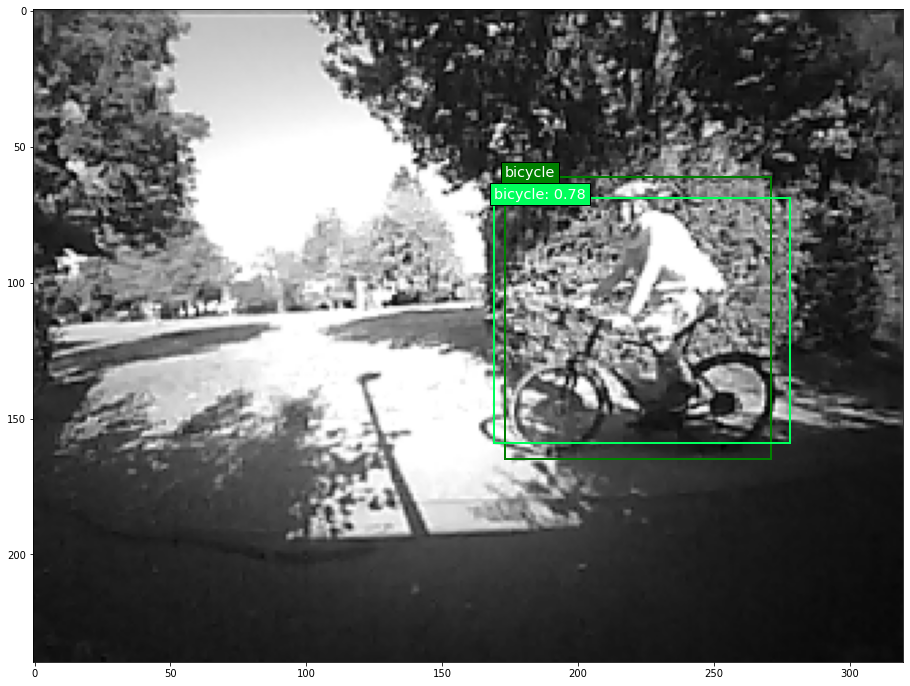

In [106]:
# 5: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background','human','bicycle','truck','car','bus']

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [ ]:
192.168.43.211_1596962113120
192.168.43.211_1596961348165